### Importing JSON per line into MongoDB

The thesis data can be loaded into MongoDB from a file with a JSON string per line with the command line:

    mongoimport --db theseus --collection thesis < theses.jl

### Establish a connection to the MongoClient, database and collection:

In [1]:
import pymongo

client = pymongo.MongoClient()
db = client['theseus']
theses = db['thesis']

### Data format

Each thesis consists of a set of keys and values.

In [2]:
thesis = theses.find_one()
thesis

{u'_id': ObjectId('5593db7641159e55c145fc2f'),
 u'abstract_en': [u"The aim of this thesis is to chart the internet video production and publishing on the  Satakunnan Kansa website and on the other Finnish dailies' websites. The study charted  the process of making a video and the specifics that have to do with internet video. The  production of internet videos at the moment in Satakunnan Kansa and other Finnish  dailies is charted in this study. This thesis also treats the future of internet videos.  The charting starts from the basic structure of video, things involved in making a video  and the specifics of distributing a video over internet. This study handles the videos that  have already been published as well on Satakunnan Kansa's website as the other dailies'  websites. The study examined the current state of publishing internet videos on the website of  Satakunnan Kansa and other dailies. The quality of the videos from the technical and  contential point of view was surveyed by

In [3]:
field_types = map(lambda (k, v): (k, type(v)), thesis.iteritems())
array_fields = map(lambda (k, v): k, filter(lambda (k, v): v == list, field_types))
field_types

[(u'identifier', list),
 (u'orientation', list),
 (u'language', list),
 (u'url', list),
 (u'abstract_fi', list),
 (u'year', list),
 (u'abstract_en', list),
 (u'documents_url', list),
 (u'titles', list),
 (u'collections', list),
 (u'abstract_sv', list),
 (u'keywords', list),
 (u'authors', list),
 (u'date', list),
 (u'organization', list),
 (u'_id', bson.objectid.ObjectId),
 (u'subjects', list),
 (u'programme', list)]

### Serializing data

In [4]:
from bson.json_util import dumps
doc = theses.find({"collections": "col_10024_238"}, {"keywords": True, "_id": False})
dumps(doc[:2])

'[{"keywords": ["mobile satellite services", "ship-to-shore communications", "marine communications", "mobile communications"]}, {"keywords": ["Layer 2", "Layer 3", "QoS", "OSPF", "campus network"]}]'

### Data size

In [5]:
n_thesis = theses.count()
n_collections = len(theses.distinct('collections'))
n_universities = len(theses.distinct('collections.0'))  # based on the hypothesis that first element is university
n_departments = len(theses.distinct('collections.1'))  # based on the hypothesis that second element is department

print "Number of thesis: %d" % n_thesis
print "Number of collections: %d" % n_collections
print "Number of universities: %d" % n_universities  # matches with http://theseus.fi/
print "Number of departments: %d" % n_departments

# FIX: 923 <> 898 + 25
# FIX: based on http://publications.theseus.fi/oai/request?verb=ListSets there are 967 collections
# FIX: some thesis belong to more than 2 collections
# universities have id com_10024_256 and departtments col_10024_232

Number of thesis: 91893
Number of collections: 923
Number of universities: 25
Number of departments: 898


### Utility functions

In [6]:
# Methods that return a pipeline

def get_count_pipeline(key):
    mongo_field = '$' + key
    return [{'$group': {'_id': mongo_field, 'count': {'$sum': 1}}},
            {'$sort': {'count': -1}}]

def get_count_unwind_pipeline(key):
    mongo_field = '$' + key
    return [{'$unwind': mongo_field},
            {'$group': {'_id': mongo_field, 'count': {'$sum': 1}}},
            {'$sort': {'count': -1}}]

def get_array_sizes_histogram_pipeline(key):
    mongo_field = '$' + key
    return [{'$project': {'count': {'$size': mongo_field}}},
            {'$group': {'_id': '$count', 'count': {'$sum': 1}}},
            {'$sort': {'_id': 1 }}]

def get_array_sizes_pipeline(key):
    mongo_field = '$' + key
    return [{'$project': {'array_size': {'$size': mongo_field}}}]


In [7]:
# for field in array_fields: print field, list(theses.aggregate(pipeline=get_array_sizes_histogram_pipeline(field)))

### Exploring array lengths for each field

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

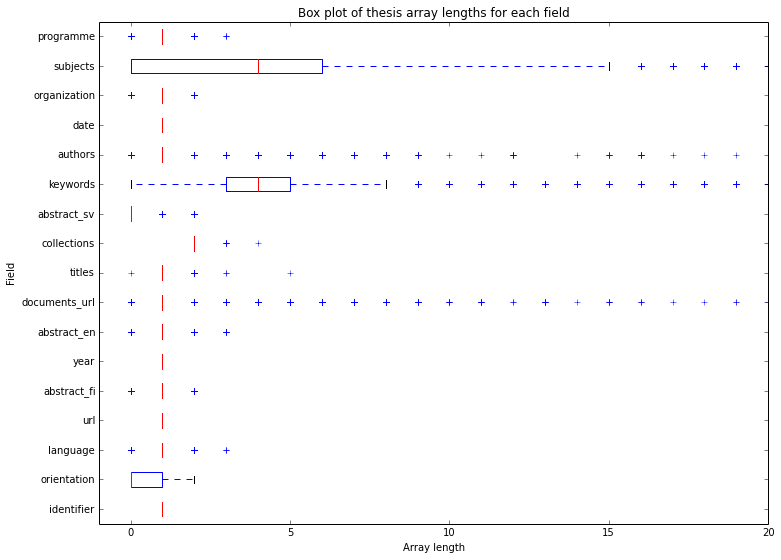

In [9]:
fig = plt.figure(figsize=[12,9])
ax = plt.axes()

data = []
for field in array_fields:
    l = list(theses.aggregate(pipeline=get_array_sizes_pipeline(field)))
    sizes = map(lambda x: x['array_size'], l)
    data.append(sizes)

ax.set_yticklabels(array_fields)
ax.set_xlim([-1,20])
plt.boxplot(data, vert=False)
plt.title("Box plot of thesis array lengths for each field")
plt.xlabel("Array length")
plt.ylabel("Field")
plt.show()

### Histogram for array lengths

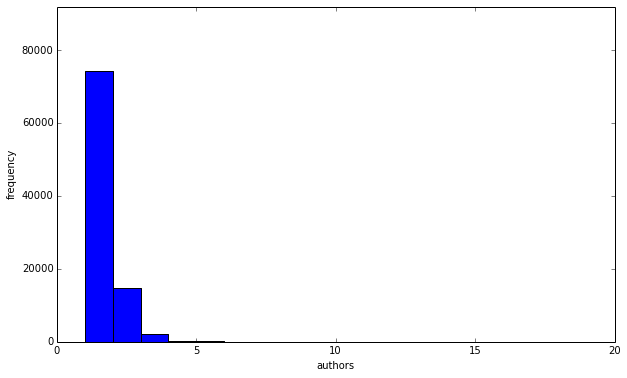

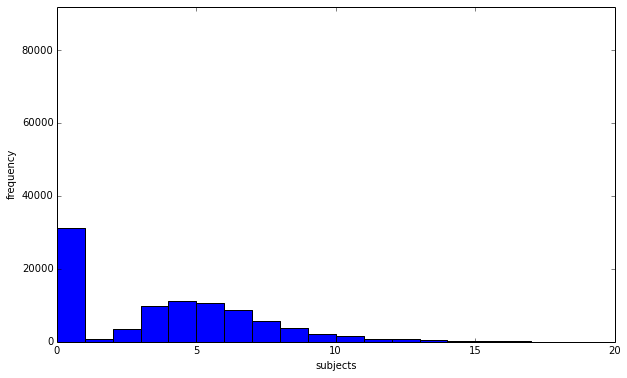

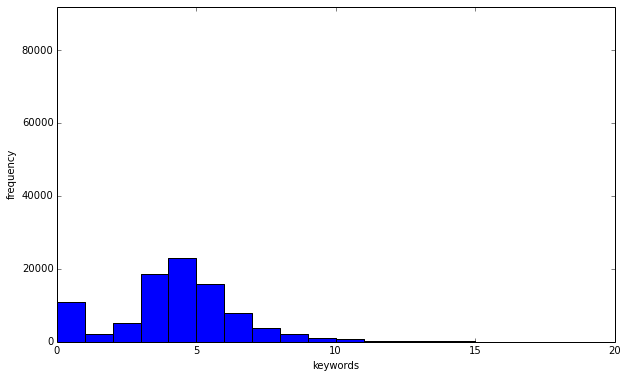

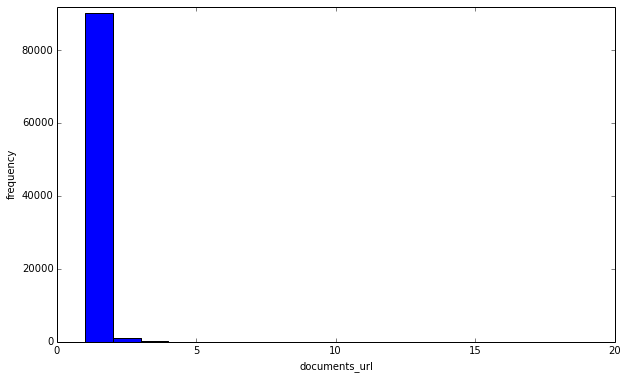

In [10]:
for field in ["authors", "subjects", "keywords", "documents_url"]:
    fig = plt.figure(figsize=[10,6])
    hist = list(theses.aggregate(pipeline=get_array_sizes_histogram_pipeline(field)))
    x = map(lambda d: d['_id'], hist)
    y = map(lambda d: d['count'], hist)
    plt.axis([0, 20, 0, n_thesis])  # [0, max(x) + 1, 0, N]
    plt.xlabel(field)
    plt.ylabel("frequency")
    plt.bar(x, y, width=1)

### Keyword and subject analysis

In [11]:
n_subjects = len(theses.distinct('subjects'))
n_keywords = len(theses.distinct('keywords'))
print "Number of different subjects: %d" % n_subjects
print "Number of different keywords: %d" % n_keywords

Number of different subjects: 30412
Number of different keywords: 117675


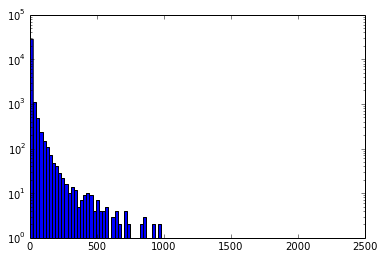

In [12]:
# Subjects frequency histogram
fd_subjects = theses.aggregate(pipeline=get_count_unwind_pipeline('subjects'))
f_subjects = map(lambda x: x['count'], fd_subjects)
plt.hist(f_subjects, bins=100, log=True)
plt.show()

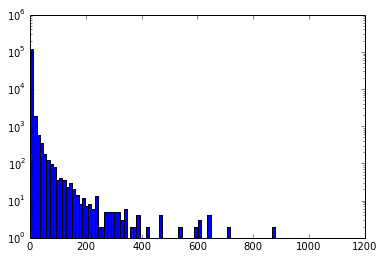

In [13]:
# Keywords frequency histogram
fd_keywords = theses.aggregate(pipeline=get_count_unwind_pipeline('keywords'))
f_keywords = map(lambda x: x['count'], fd_keywords)
plt.hist(f_keywords, bins=100, log=True)
plt.show()

## Most popular keywords and subjects

In [14]:
keyword_count = list(theses.aggregate(pipeline=get_count_unwind_pipeline('keywords')))
for i in range(10): print keyword_count[i]

{u'count': 1155, u'_id': u'markkinointi'}
{u'count': 1110, u'_id': u'asiakastyytyv\xe4isyys'}
{u'count': 1075, u'_id': u'kehitt\xe4minen'}
{u'count': 927, u'_id': u'laatu'}
{u'count': 915, u'_id': u'ty\xf6hyvinvointi'}
{u'count': 890, u'_id': u'varhaiskasvatus'}
{u'count': 873, u'_id': u'nuoret'}
{u'count': 868, u'_id': u'sosiaalinen media'}
{u'count': 790, u'_id': u'osallisuus'}
{u'count': 710, u'_id': u'kvalitatiivinen tutkimus'}


In [15]:
subject_count = list(theses.aggregate(pipeline=get_count_unwind_pipeline('subjects')))
for i in range(10): print subject_count[i]

{u'count': 2336, u'_id': u'markkinointi'}
{u'count': 2255, u'_id': u'kehitt\xe4minen'}
{u'count': 1714, u'_id': u'nuoret'}
{u'count': 1702, u'_id': u'lapset'}
{u'count': 1574, u'_id': u'laatu'}
{u'count': 1563, u'_id': u'suunnittelu'}
{u'count': 1427, u'_id': u'yritykset'}
{u'count': 1420, u'_id': u'asiakastyytyv\xe4isyys'}
{u'count': 1320, u'_id': u'palvelut'}
{u'count': 1252, u'_id': u''}


### Dsitribution of field values

In [16]:
language_values = theses.aggregate(pipeline=get_count_unwind_pipeline('language'))
print list(language_values)

[{u'count': 79813, u'_id': u'fi'}, {u'count': 8649, u'_id': u'en'}, {u'count': 3367, u'_id': u'sv'}, {u'count': 689, u'_id': u''}, {u'count': 12, u'_id': u'fr'}, {u'count': 11, u'_id': u'fi, en'}, {u'count': 10, u'_id': u'ru'}, {u'count': 8, u'_id': u'other'}, {u'count': 6, u'_id': u'de'}, {u'count': 1, u'_id': u'eng'}, {u'count': 1, u'_id': u'akuuttihoito'}, {u'count': 1, u'_id': u'selkokieli'}, {u'count': 1, u'_id': u'et'}, {u'count': 1, u'_id': u'swe'}, {u'count': 1, u'_id': u'zh'}]


### Dealing with dates

In [17]:
from datetime import datetime

d = theses.find_one()['date'][0]

def parse_date(d):
    return datetime.strptime(d, '%Y-%m-%dT%H:%M:%SZ')

parsed_date = parse_date(d)

In [18]:
print parsed_date

2013-08-19 10:18:05


## Trends

In [19]:
def project(d, base):
    """returns a list of values for a common base
    Args:
        d: mapping between key and count
        base: list of ordered keys of same size as d    
    Returns:
    """
    result = []
    for b in base:
        if b in d:
            result.append(d[b])
        else:
            result.append(0)
    return result


assert project({'2015': 13, '2014': 11}, ['2013', '2014', '2015']) == [0, 11, 13]


def get_counts(base, keyword=None):
    """returns a list with the number of theses per year with a base"""
    pipeline = [ {"$unwind": "$year"},
                 {"$group": {"_id": "$year", "count": {"$sum": 1}}},
                 {"$sort": {"count": -1}} ]
    if keyword is not None:
        pipeline.insert(0, {"$match": {"keywords": keyword}})  # filter thesis by keyword
    l = theses.aggregate(pipeline=pipeline)
    d = {d['_id']: d['count'] for d in l if d['_id'] in base}
    return project(d, base)

## Total number of theses per year

['2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']


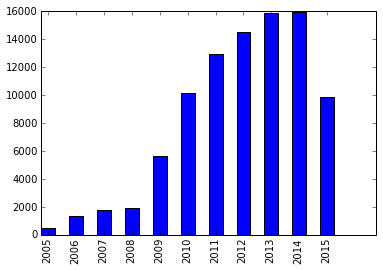

In [20]:
import numpy as np

years = [str(2000 + i) for i in range(5, 16)]  # 2005 -> 2015

print years

totals = get_counts(years)

width = 0.5
N = len(years)
ind = np.arange(N)

plt.bar(ind, totals, width=width)
plt.xticks(ind + width/2.0, years, rotation='vertical')
plt.show()

## Number of theses with a keyword by year

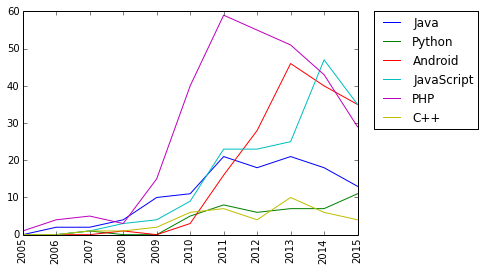

In [28]:
def plot_counts(keywords, years):
    
    for keyword in keywords:
        counts = get_counts(years, keyword=keyword)  # number of theses with KEYWORD per year
        plt.plot(counts, label=keyword)

    # Add years to x axis

    ind = range(len(years))
    plt.xticks(ind, years, rotation='vertical')
    #plt.legend(loc='upper left')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

keywords = ["Java", "Python", "Android", "JavaScript", "PHP", "C++"]
plot_counts(keywords, years)

## Percentage of theses with a keyword by year

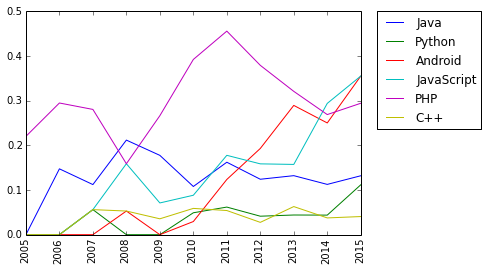

In [29]:

def plot_frequencies(keywords, years):
    
    for keyword in keywords:
        counts = get_counts(years, keyword=keyword)  # number of theses with KEYWORD per year
        frequencies =[100*count/float(total) for (count, total) in zip(counts, totals)]
        plt.plot(frequencies, label=keyword)

    # Add years to x axis
    N = len(years)
    ind = range(N)
    plt.xticks(ind, years, rotation='vertical')
    #plt.legend(loc='upper left')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
plot_frequencies(keywords, years)

## Most popular of all times keywords trends

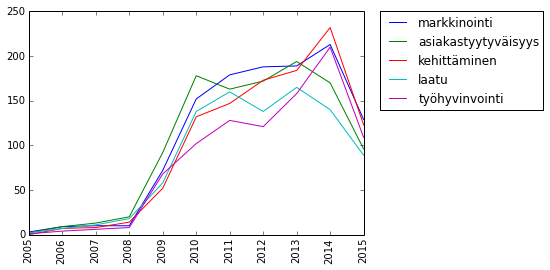

In [26]:
keywords = map(lambda x: x["_id"], keyword_count)[:5]  # most popular keywords

plot_counts(keywords, years)


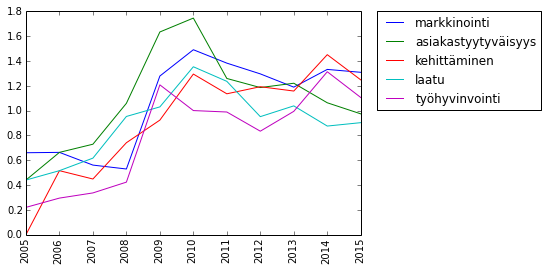

In [27]:
plot_frequencies(keywords, years)

## Conclusion
- Data is fairly sparse, and most subjects and keywords appear with small frequencies
- For the last year (2015) not all the theses have been uploaded. Thus, a relative count should be used for analyzing trends. Instead of counting number of theses per year, we count % of thesis with that topic per year

## TODO
- Should have number of keywords which frequency is <2, <5, <10, <100, <100 ...
- Same trend analysis should be done with combined and normalized (lowercase) subjects and keywords into topics